In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import numpy
import torch.utils.data
from sklearn.model_selection import train_test_split

# Display Dataset

In [2]:
import sys
sys.path.append('..')
import seaborn as sns

from Datasets.LorenzAttractor import LorenzAttractor
from mpl_toolkits.mplot3d import Axes3D

attractor = LorenzAttractor(sample_len=10000, n_samples=10, xyz=[1.0, 1.0, 1.0], sigma=10.0, b=8/3, r=28.0)
attractor_samp = attractor[0]

In [3]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=attractor_samp[:,0].numpy(), y=attractor_samp[:,1].numpy(), z=attractor_samp[:,2].numpy(),
    mode='lines',
    line=dict(color='blue', width=2)
)])

fig.update_layout(
    title='Lorenz Attractor Trajectory',
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    )
)

fig.show()

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('CPU is available')


CPU is available


# ESN 

In [5]:
from Models.Reservoir import Reservoir

In [6]:
time = torch.linspace(0, 10, 1000)
x_inputs = attractor_samp[:-1, 0]
x_targets = attractor_samp[1:, 0]
y_inputs = attractor_samp[:-1, 1]
y_targets = attractor_samp[1:, 1]
z_inputs = attractor_samp[:-1, 2]
z_targets = attractor_samp[1:, 2]

# Combine inputs and targets
inputs = torch.stack([x_inputs, y_inputs, z_inputs], dim=1)
targets = torch.stack([x_targets, y_targets, z_targets], dim=1)

# Normalize data to [-1, 1]
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min()) * 2 - 1
targets = (targets - targets.min()) / (targets.max() - targets.min()) * 2 - 1

print (inputs.shape, targets.shape)

# Split into train and test
train_data, test_data = inputs[:800], inputs[800:]

# Initialize ESN
Res = Reservoir(input_dim=3, reservoir_dim=300, output_dim=1, 
                spectral_radius=0.90, leak_rate=0.3)

torch.Size([9999, 3]) torch.Size([9999, 3])


In [7]:
eigenvalues, _ = torch.linalg.eig(Res.W)
λ_max = torch.max(torch.abs(eigenvalues))
print(f"Actual λ_max after scaling: {λ_max.item()} (should match spectral radius {Res.spectral_radius})")

Actual λ_max after scaling: 0.9000000357627869 (should match spectral radius 0.9)


In [8]:
x_inputs.shape, x_targets.shape

(torch.Size([9999]), torch.Size([9999]))

In [9]:
Res.train_readout(x_inputs, x_targets)

RuntimeError: both arguments to matmul need to be at least 1D, but they are 2D and 0D

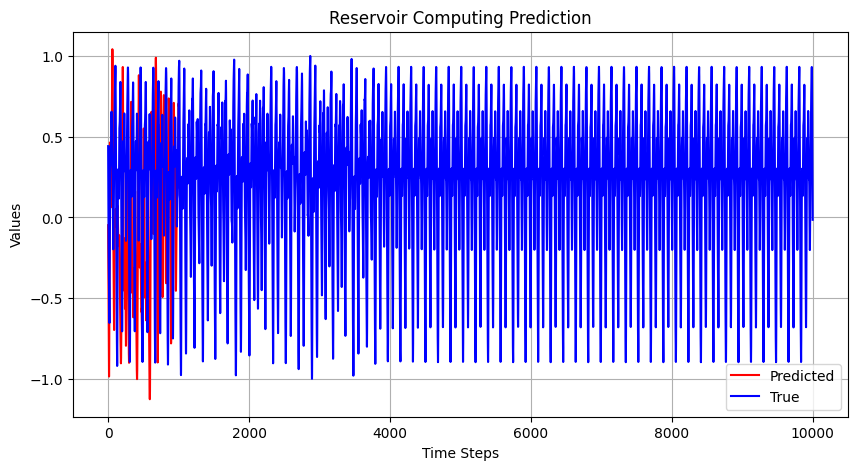

In [ ]:
predictions = Res.predict(train_data[-1:], steps=1000)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(predictions, label='Predicted', color='red')
plt.plot(targets, label='True', color='blue')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.title('Reservoir Computing Prediction')
plt.show()


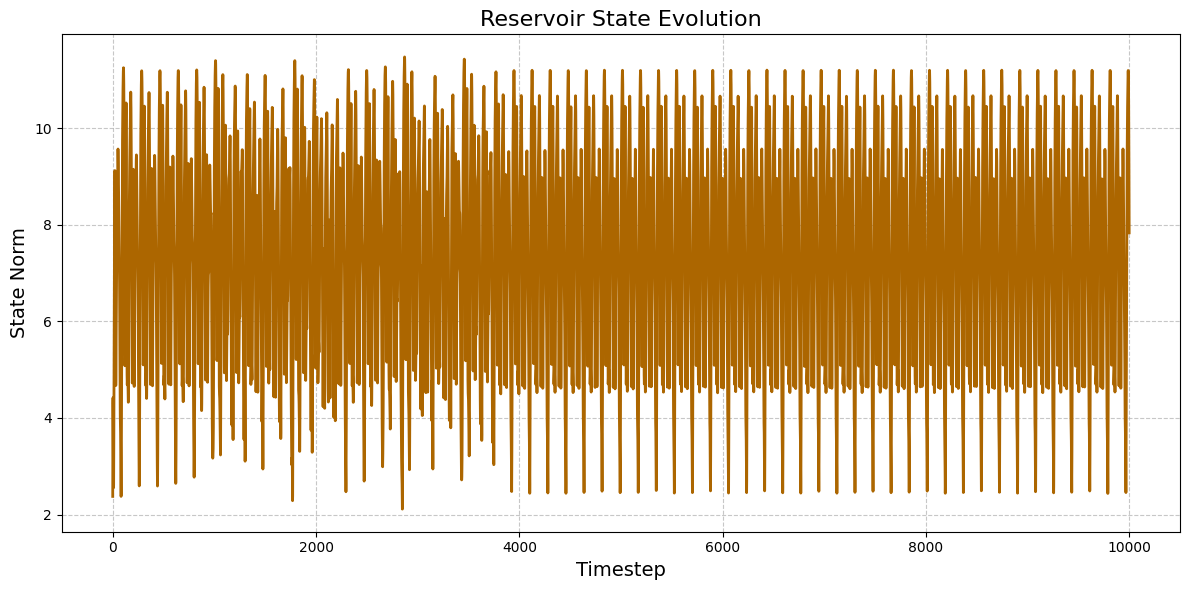

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot([state.norm().item() for state in Res.reservoir_states], color='#AC6600', linewidth=2)
plt.xlabel("Timestep", fontsize=14)
plt.ylabel("State Norm", fontsize=14)
plt.title("Reservoir State Evolution", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

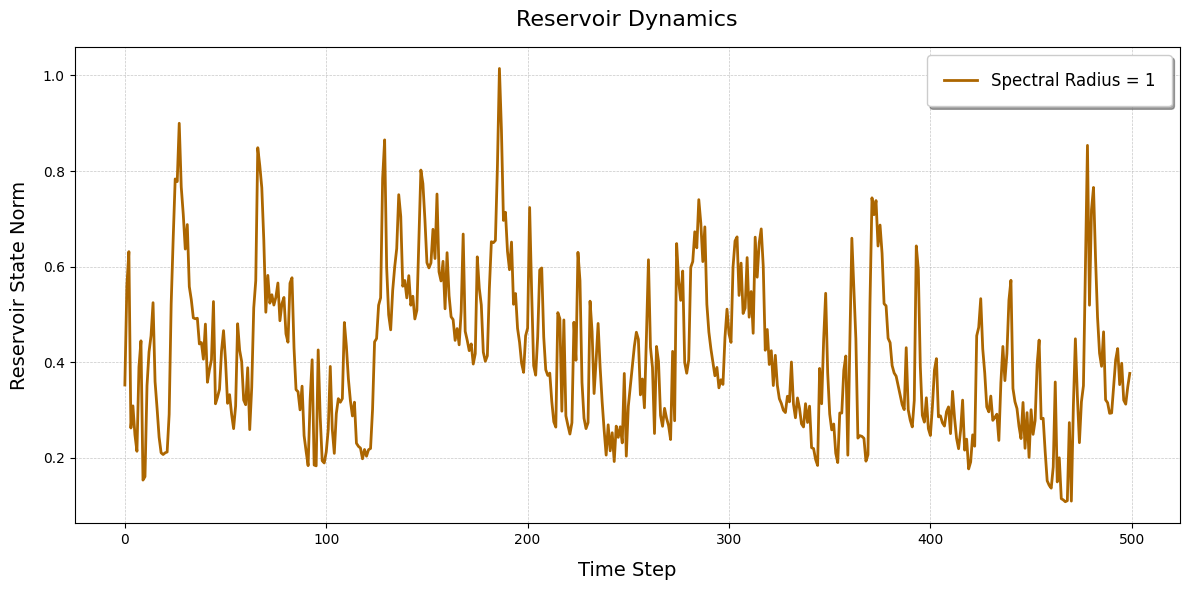

Approximate Lyapunov Exponent: -3.0907
Stable / Periodic Dynamics


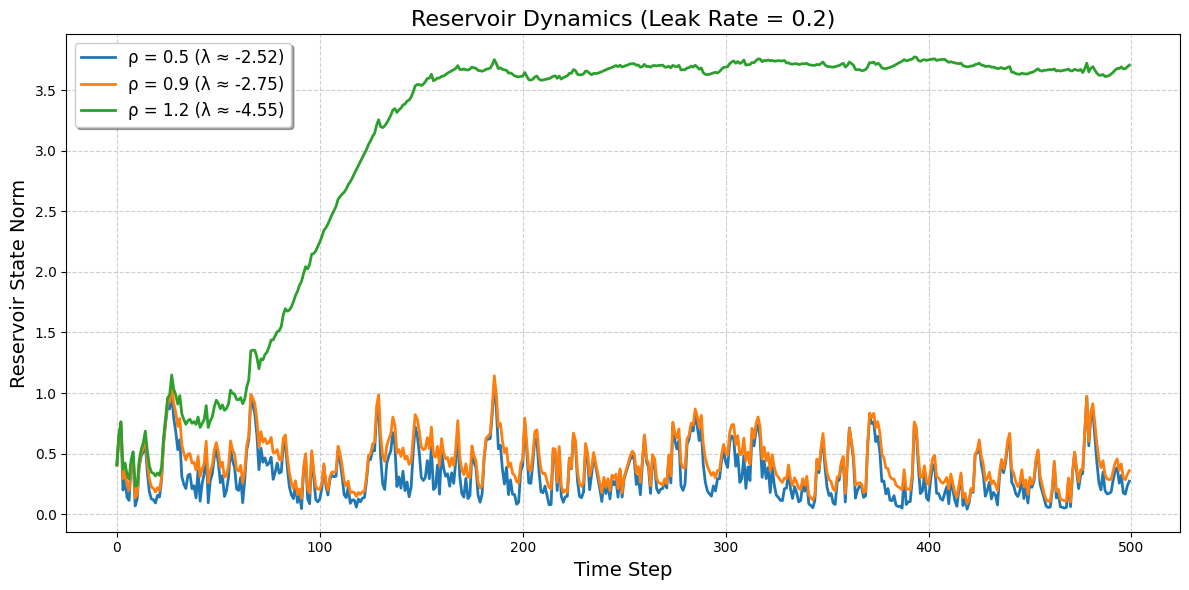

In [ ]:
from HelperScripts.Testers import Test_lyapunov,Test_Spectral_radii
Test_lyapunov(spectral_radius=1)
Test_Spectral_radii()